<a href="https://colab.research.google.com/github/sharon-kurant/backprop_from_scratch/blob/main/homework2_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Convolutional neural networks

(60 points)


Submitted by:

 **Student 1 Name+ID

 **Student 2 Name+ID

**Assignment Instruction:**

· Submissions in pairs only.

· The code must be written in Python 3.7+

· You are allowed to use only Pytorch, numpy, PIL and matplotlib as external libraries

· The code must be reasonably documented

· You should save a copy of the notebook to your Drive and answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

· If you wish to work in your IDE, make a `.py` copy of the notebook, but as you finish insert the script back to the matching cells of the notebook.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).


In [ ]:
# Add Imports and magic commands
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import top_k_accuracy_score
import time
# Use .to(device) when needed to train on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

cuda


## Part 1: CIFAR10 classification
In this assignment you'll implement models for CIFAR10 objects classification using CNNs. You'll
decide about the architecture and training details.

**Data Loader:** (10 points)
1. Compose a transformation for the cifar10 dataset. Sizes of each image will be 3 * 32 * 32.
2. Download and costruct the CIFAR10 dataset using ```
torchvision.datasets.CIFAR10```. Load both train and test sets. and split validation set from train in a ratio of 80% train, 20% validation.
3. Construct a dataloader with ```num_workers=4, batch_size=64```.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
num_workers = 4

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

indices = list(range(len(trainset))) # 50K
np.random.shuffle(indices)

p = 0.2
split = int(np.floor(p * len(trainset))) # 10K
train_sample = SubsetRandomSampler(indices[split:])
val_sample = SubsetRandomSampler(indices[:split])


train_loader = torch.utils.data.DataLoader(trainset, sampler = train_sample, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(trainset, sampler = val_sample, batch_size=batch_size, num_workers=num_workers)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('train set len', len(train_loader.sampler.indices))
print('validation set len', len(val_loader.sampler.indices))
print('test set len', len(test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000


**Models:** (20 points)

Please define the following models (with same architecture you choose):
1. Model without dropout and batch normalization.
2. Model with batch normalization and without dropout.
3. Model with dropout and batch normalization. 
4. Model with dropout and batch normalization and without FC layers (convert your
network to fully convolutional network as we saw in the tutorial).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, **kwargs: dict):
        super().__init__()
        layers = []

        layers += [nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(32)]
        if kwargs['dropout']:
          layers += [nn.Dropout(0.2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(64)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(2)]

        layers += [nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(64)]
        if kwargs['dropout']:
          layers += [nn.Dropout(0.2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(2)]

        layers += [nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(128)]
        if kwargs['dropout']:
          layers += [nn.Dropout(0.2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)]
        if kwargs['batch_norm']:
          layers += [nn.BatchNorm2d(256)]
        layers += [nn.ReLU()]
        layers += [nn.MaxPool2d(2)]

        if kwargs['fully_conv']:
          
          if kwargs['dropout']:
            layers += [nn.Dropout(0.5)]
          layers += [nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=4)] # from 16*5*5 to 120*1*1 (no padding or strides)
          if kwargs['batch_norm']:
            layers += [nn.BatchNorm2d(1024)]
          layers += [nn.ReLU()]
          
          if kwargs['dropout']:
            layers += [nn.Dropout(0.5)]
          layers += [nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1)] # 1x1 conv
          if kwargs['batch_norm']:
            layers += [nn.BatchNorm2d(512)]
          layers += [nn.ReLU()]
          layers += [nn.Conv2d(in_channels=512, out_channels=10, kernel_size=1)]  # 1x1 conv
        else:
          layers += [nn.Flatten()]
          if kwargs['dropout']:
            layers += [nn.Dropout(0.5)]
          layers += [nn.Linear(256*4*4, 1024)]
          if kwargs['batch_norm']:
            layers += [nn.BatchNorm1d(1024)]
          layers += [nn.ReLU()]
          if kwargs['dropout']:
            layers += [nn.Dropout(0.5)]
          layers += [nn.Linear(1024, 512)]
          if kwargs['batch_norm']:
            layers += [nn.BatchNorm1d(512)]
          layers += [nn.ReLU()]
          layers += [nn.Linear(512, 10)]
        self.seq = nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.seq(x)
        return x

    def to_string(self):
      s = f'CNN with batch_norm={kwargs['batch_norm']}, dropout={kwargs['dropout']} and fully_conv={kwargs['fully_conv']}'
      return s

**Training:** (20 points)
1. Write the training procedure for our task
2. Decide what is the best optimizer for this task, learning rate and other hyperparameters
3. Use cross entropy loss function
4. Calculate validation top-1 and top-5 accuracies at the end of each training epoch. You may use ```sklearn.metrics.top_k_accuracy_score```
4. Please use early stopping regularization using top-1 accuracy.
5. Train the 4 models, plot the train and validation losses and validation accuracies.

In [ ]:
net1 = Net(fully_conv = False ,dropout = False, batch_norm = False)
net2 = Net(fully_conv = False ,dropout = False, batch_norm = True)
net3 = Net(fully_conv = False ,dropout = True, batch_norm = True)
net4 = Net(fully_conv = True ,dropout = True, batch_norm = True)
nets = [net1,net2,net3,net4]


optimizers = [torch.optim.Adam(net.parameters(),  lr=0.001) for net in nets]

loss_fn = nn.CrossEntropyLoss()


dict_loss = {}
dict_top1 = {}
dict_top5 = {}


patience = 5

for i, (net,optimizer) in enumerate(zip(nets,optimizers),1):
  triggers = 0
  net.cuda()
  dict_loss[i] = {'train': [], 'val': [], 'test': []}
  dict_top1[i] = {'train': [], 'val': [], 'test': []}
  dict_top5[i] = {'train': [], 'val': [], 'test': []}
  best_top_1_val = -np.Inf

  for epoch in range(30):
    epoch_start_time = time.time()
    ################# TRAIN #################
    train_loss = 0.0
    top_5_train_list = []
    top_1_train_list = []

    net.train()
    for data, labels in train_loader:
    # Transfer Data to GPU if available
      if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()
      
      # Clear the gradients
      optimizer.zero_grad()
      # Forward Pass
      predictions = net(data)
      if predictions.size() != (len(labels),10):
        predictions = predictions.squeeze()
      # Find the Loss
      loss = loss_fn(predictions,labels)
      # Calculate gradients
      loss.backward()
      # Update Weights
      optimizer.step()
      # Calculate Loss
      train_loss += loss.item()

      # overall to k accuracy
      with torch.no_grad():
        top_5_train_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 5, labels=list(trainset.class_to_idx.values()))]
        top_1_train_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 1, labels=list(trainset.class_to_idx.values()))]

    top_5_train_avg = np.mean(top_5_train_list)
    top_1_train_avg = np.mean(top_1_train_list)
    train_loss = train_loss / len(train_loader)
    dict_loss[i]['train'].append(train_loss)
    dict_top1[i]['train'].append(top_1_train_avg)
    dict_top5[i]['train'].append(top_5_train_avg)
      
    ################## EVAL ##################
    val_loss = 0.0
    top_5_val_list = []
    top_1_val_list = []

    net.eval()
    for data, labels in val_loader:
      
    # Transfer Data to GPU if available
      if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()
      
      # Forward Pass
      predictions = net(data)
      if predictions.size() != (len(labels),10):
        predictions = predictions.squeeze()
      # Find the Loss
      loss = loss_fn(predictions,labels)
      # Calculate Loss
      val_loss += loss.item()

      # overall top k accuracy
      with torch.no_grad():
        top_5_val_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 5, labels=list(trainset.class_to_idx.values()))]
        top_1_val_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 1, labels=list(trainset.class_to_idx.values()))]

    val_loss = val_loss / len(val_loader)
    top_5_val_avg = np.mean(top_5_val_list)
    top_1_val_avg = np.mean(top_1_val_list)
    dict_loss[i]['val'].append(val_loss)
    dict_top1[i]['val'].append(top_1_val_avg)
    dict_top5[i]['val'].append(top_5_val_avg)
      
    epoch_end_time = time.time() - epoch_start_time
    print(f'{epoch_end_time:.1f}s: Epoch {epoch+1} - Net{i}\n\t|\t Training Loss: {train_loss:.3f} \t|\t Validation Loss: {val_loss:.3f} \n\t|\t Training Acc: {top_1_train_avg:.3f} \t|\t Validation Acc: {top_1_val_avg:.3f}')

    # Early Stopping
    if best_top_1_val < top_1_val_avg:
        best_top_1_val = top_1_val_avg
        checkpoint = {'epoch': epoch,
                      'model_state_dict': net.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'top_1_val_avg': top_1_val_avg,
                      }
        # torch.save(checkpoint, '\data\early_stopping_model')
        print('\t\t  triggers reset')
        triggers = 0
      
    else:
      triggers+=1
      print(f'\t\t  triggers is {triggers}')
      if patience == triggers:
        print(f'model lost its patience!')
        #checkpoint = torch.load('\data\early_stopping_model')
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        top_1_val_avg = checkpoint['top_1_val_avg']
        break

  ################## TEST ##################
  test_loss = 0.0
  top_5_test_list = []
  top_1_test_list = []
  for data, labels in test_loader:
  # Transfer Data to GPU if available
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
    
    # Forward Pass
    predictions = net(data)
    if predictions.size() != (len(labels),10):
      predictions = predictions.squeeze()

    # overall to k accuracy
    with torch.no_grad():
      top_5_test_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 5, labels=list(trainset.class_to_idx.values()))]
      top_1_test_list += [top_k_accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy(), k = 1, labels=list(trainset.class_to_idx.values()))]


  top_5_test_avg = np.mean(top_5_test_list)
  top_1_test_avg = np.mean(top_1_test_list)
  dict_top1[i]['test'].append(top_1_test_avg)
  dict_top5[i]['test'].append(top_5_test_avg)

  print(f'finished net{i}\n')

16.1s: Epoch 1 - Net1
	|	 Training Loss: 1.692 	|	 Validation Loss: 1.298 
	|	 Training Acc: 0.369 	|	 Validation Acc: 0.529
		  triggers reset
0.5288614649681529 0.5288614649681529
16.1s: Epoch 2 - Net1
	|	 Training Loss: 1.160 	|	 Validation Loss: 1.033 
	|	 Training Acc: 0.581 	|	 Validation Acc: 0.628
		  triggers reset
0.6280851910828026 0.6280851910828026
16.1s: Epoch 3 - Net1
	|	 Training Loss: 0.907 	|	 Validation Loss: 0.904 
	|	 Training Acc: 0.677 	|	 Validation Acc: 0.681
		  triggers reset
0.6809315286624203 0.6809315286624203
16.2s: Epoch 4 - Net1
	|	 Training Loss: 0.746 	|	 Validation Loss: 0.821 
	|	 Training Acc: 0.736 	|	 Validation Acc: 0.715
		  triggers reset
0.7151671974522293 0.7151671974522293
16.1s: Epoch 5 - Net1
	|	 Training Loss: 0.612 	|	 Validation Loss: 0.760 
	|	 Training Acc: 0.783 	|	 Validation Acc: 0.739
		  triggers reset
0.7388535031847133 0.7388535031847133
16.0s: Epoch 6 - Net1
	|	 Training Loss: 0.495 	|	 Validation Loss: 0.753 
	|	 Training Ac

Top 1 Accuracy Validation


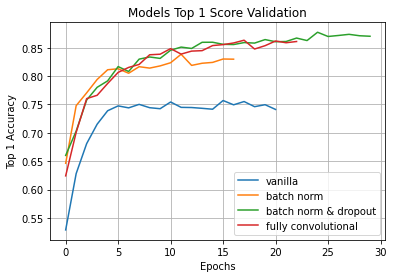


Top 5 Accuracy Validation


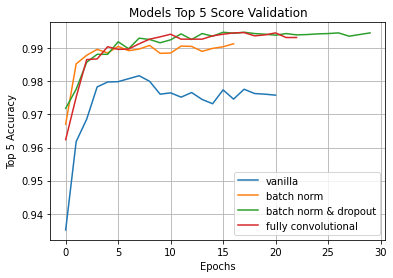


Validation Losses


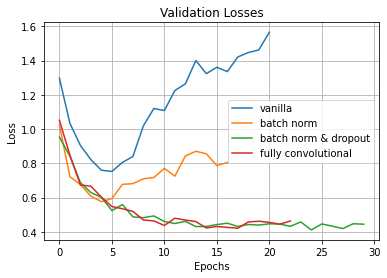


Train Losses


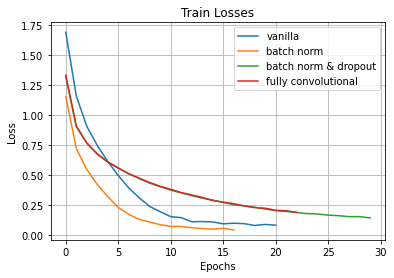

In [ ]:
def make_plots():
  print(f'Top 1 Accuracy Validation')
  plt.plot(dict_top1[1]['val'])
  plt.plot(dict_top1[2]['val'])
  plt.plot(dict_top1[3]['val'])
  plt.plot(dict_top1[4]['val'])
  plt.grid()
  plt.title('Models Top 1 Score Validation')
  plt.ylabel('Top 1 Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['vanilla', 'batch norm','batch norm & dropout', 'fully convolutional'])
  plt.show()
  
  print('')

  print(f'Top 5 Accuracy Validation')
  plt.plot(dict_top5[1]['val'])
  plt.plot(dict_top5[2]['val'])
  plt.plot(dict_top5[3]['val'])
  plt.plot(dict_top5[4]['val'])
  plt.grid()
  plt.title('Models Top 5 Score Validation')
  plt.ylabel('Top 5 Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['vanilla', 'batch norm','batch norm & dropout', 'fully convolutional'])
  plt.show()

  print('')

  print(f'Validation Losses')
  plt.plot(dict_loss[1]['val'])
  plt.plot(dict_loss[2]['val'])
  plt.plot(dict_loss[3]['val'])
  plt.plot(dict_loss[4]['val'])
  plt.grid()
  plt.title('Validation Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['vanilla', 'batch norm','batch norm & dropout', 'fully convolutional'])
  plt.show()

  print('')

  print(f'Train Losses')
  plt.plot(dict_loss[1]['train'])
  plt.plot(dict_loss[2]['train'])
  plt.plot(dict_loss[3]['train'])
  plt.plot(dict_loss[4]['train'])
  plt.grid()
  plt.title('Train Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['vanilla', 'batch norm','batch norm & dropout', 'fully convolutional'])
  plt.show()

make_plots()

**Evaluation:** (10 points)
1. Calculate top-1 and top-5 accuraccy metrics on the test test set for each of the networks and show it in the notebook.

In [ ]:
for i, net in enumerate(nets,1):
  print(nets[i-1].to_string())
  print(f'Net {i} Acccuracy:\ttop-1: {dict_top1[i]["test"][0]}\ttop-5: {dict_top5[i]["test"][0]}')
  # print(dict_top1[i]['test'])
  # print(dict_top5[i]['test'])

Net 1 Acccuracy:	top-1: 0.7426353503184714	top-5: 0.9739251592356688
Net 2 Acccuracy:	top-1: 0.8218550955414012	top-5: 0.9895501592356688
Net 3 Acccuracy:	top-1: 0.8673367834394905	top-5: 0.993531050955414
Net 4 Acccuracy:	top-1: 0.8541003184713376	top-5: 0.9939291401273885
